<a href="https://colab.research.google.com/github/Praxis-QR/FDS/blob/main/FinTech_4__Efficient_Frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)<br>
<hr>

![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/YantraJaalBanner.png)<br>


<hr>

[Prithwis Mukerjee](http://www.linkedin.com/in/prithwis)<br>

In [1]:
from datetime import datetime
import pytz
print('Tested on ',datetime.now(pytz.timezone('Asia/Calcutta')))
!python --version
!lsb_release -a

Tested on  2024-01-04 09:52:28.007595+05:30
Python 3.10.12
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


#Portfolio Optimisation with Efficient Frontier <br>

What is [Markowitz Efficient Frontier](https://www.investopedia.com/terms/e/efficientfrontier.asp)?

Portfolio Optimisation by Shruti Dash https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.to_datetime('today').strftime('%d %B %Y')

'04 January 2024'

#Data Acquisition

BSE Site BSE Historical Data is available at https://www.bseindia.com/markets/equity/EQReports/StockPrcHistori.html?flag=0 <br>


Index data is available here https://www1.nseindia.com/products/content/equities/indices/historical_index_data.htm <br>

In [3]:
!wget -q -O bharti.csv https://raw.githubusercontent.com/Praxis-QR/FDS/main/data/fintech/BSE_Bharti-2020-2022.csv
!wget -q -O hulv.csv https://raw.githubusercontent.com/Praxis-QR/FDS/main/data/fintech/BSE_HULV-2020-2022.csv
!wget -q -O lnto.csv https://raw.githubusercontent.com/Praxis-QR/FDS/main/data/fintech/BSE_LNT-2020-2022.csv
!wget -q -O hdfc.csv https://raw.githubusercontent.com/Praxis-QR/FDS/main/data/fintech/BSE_HDFC-2020-2022.csv

In [4]:
def BSEdata(fileName, secName):
    df = pd.read_csv(fileName, delimiter =',')
    df['Date'] = pd.to_datetime(df['Date'])
    dropColumns = [ 'Open Price','High Price','Low Price','WAP',  'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low', 'Spread Close-Open','No. of Trades','Total Turnover (Rs.)','No.of Shares']
    df.drop(dropColumns, axis =1, inplace = True)
    df = df.rename(columns ={'Close Price':secName})
    #df = df.loc[::-1]                                                # clever way to reverse the order of rows, however we are using the sort
    df.sort_values('Date', axis = 0, inplace = True)
    df.set_index('Date',inplace=True)
    return df

In [5]:
dfBHAR = BSEdata('bharti.csv', 'BHAR')
dfHULV = BSEdata('hulv.csv','HULV')
dfHDFC = BSEdata('hdfc.csv','HDFC')
dfLNTO = BSEdata('lnto.csv','LNTO')

#Tale of Two Returns
LogReturns and Simple Returns <br>
https://www.portfolioprobe.com/2010/10/04/a-tale-of-two-returns/

In [6]:
df = pd.merge(dfLNTO,pd.merge(dfHULV,pd.merge(dfHDFC,dfBHAR,on='Date'),on='Date'),on='Date')
df.head()

,LNTO,HULV,HDFC,BHAR
Date,,,,
2019-12-31,1298.95,1923.25,1271.80,455.8
2020-01-01,1310.10,1936.75,1279.05,453.3
2020-01-02,1345.00,1938.15,1286.65,455.0
2020-01-03,1335.15,1928.75,1268.10,455.0
2020-01-06,1316.30,1915.55,1241.15,449.5


##Log Returns

In [7]:
#Daily Log Returns
dailyLogReturns = df.pct_change().apply(lambda x: np.log(1+x))
dailyLogReturns.head()

,LNTO,HULV,HDFC,BHAR
Date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-01,0.008547,0.006995,0.005684,-0.005500
2020-01-02,0.026291,0.000723,0.005924,0.003743
2020-01-03,-0.007350,-0.004862,-0.014522,0.000000
2020-01-06,-0.014219,-0.006867,-0.021481,-0.012162


In [8]:
dailyLogReturns['Year'] = dailyLogReturns.index.year
dailyLogReturns.head()

,LNTO,HULV,HDFC,BHAR,Year
Date,,,,,
2019-12-31,NaN,NaN,NaN,NaN,2019
2020-01-01,0.008547,0.006995,0.005684,-0.005500,2020
2020-01-02,0.026291,0.000723,0.005924,0.003743,2020
2020-01-03,-0.007350,-0.004862,-0.014522,0.000000,2020
2020-01-06,-0.014219,-0.006867,-0.021481,-0.012162,2020


In [9]:
# logReturns are additive!
annualLogReturns = dailyLogReturns.groupby('Year').sum()
annualLogReturns

,LNTO,HULV,HDFC,BHAR
Year,,,,
2019,0.000000,0.000000,0.000000,0.000000
2020,-0.008815,0.218761,0.121950,0.110983
2021,0.386478,-0.014222,0.029523,0.294701
2022,0.096173,0.081354,0.095015,0.165213


In [10]:
#Calculate Simple Returns from Log Returns
annualLogReturns['LNTO_SR'] = np.exp(annualLogReturns['LNTO']) - 1
annualLogReturns['HULV_SR'] = np.exp(annualLogReturns['HULV']) - 1
annualLogReturns['HDFC_SR'] = np.exp(annualLogReturns['HDFC']) - 1
annualLogReturns['BHAR_SR'] = np.exp(annualLogReturns['BHAR']) - 1
annualLogReturns

,LNTO,HULV,HDFC,BHAR,LNTO_SR,HULV_SR,HDFC_SR,BHAR_SR
Year,,,,,,,,
2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020,-0.008815,0.218761,0.121950,0.110983,-0.008776,0.244534,0.129698,0.117376
2021,0.386478,-0.014222,0.029523,0.294701,0.471788,-0.014121,0.029963,0.342725
2022,0.096173,0.081354,0.095015,0.165213,0.100950,0.084755,0.099676,0.179645


## Simple Returns

In [11]:
#Year End Prices
df.resample('Y').last()

,LNTO,HULV,HDFC,BHAR
Date,,,,
2019-12-31,1298.95,1923.25,1271.80,455.80
2020-12-31,1287.55,2393.55,1436.75,509.30
2021-12-31,1895.00,2359.75,1479.80,683.85
2022-12-31,2086.30,2559.75,1627.30,806.70


In [12]:
annualSimpleReturns = df.resample('Y').last().pct_change()
annualSimpleReturns
#Compare with Simple Returns computed from Log Returns

,LNTO,HULV,HDFC,BHAR
Date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-12-31,-0.008776,0.244534,0.129698,0.117376
2021-12-31,0.471788,-0.014121,0.029963,0.342725
2022-12-31,0.100950,0.084755,0.099676,0.179645


In [13]:
#Compute Log Returns from Simple Returns
annualSimpleReturns['LNTO_LR'] = np.log(annualSimpleReturns['LNTO']+1)
annualSimpleReturns['HULV_LR'] = np.log(annualSimpleReturns['HULV']+1)
annualSimpleReturns['HDFC_LR'] = np.log(annualSimpleReturns['HDFC']+1)
annualSimpleReturns['BHAR_LR'] = np.log(annualSimpleReturns['BHAR']+1)
annualSimpleReturns
#Compare with original set of Log Returns

,LNTO,HULV,HDFC,BHAR,LNTO_LR,HULV_LR,HDFC_LR,BHAR_LR
Date,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,-0.008776,0.244534,0.129698,0.117376,-0.008815,0.218761,0.121950,0.110983
2021-12-31,0.471788,-0.014121,0.029963,0.342725,0.386478,-0.014222,0.029523,0.294701
2022-12-31,0.100950,0.084755,0.099676,0.179645,0.096173,0.081354,0.095015,0.165213


##Charts

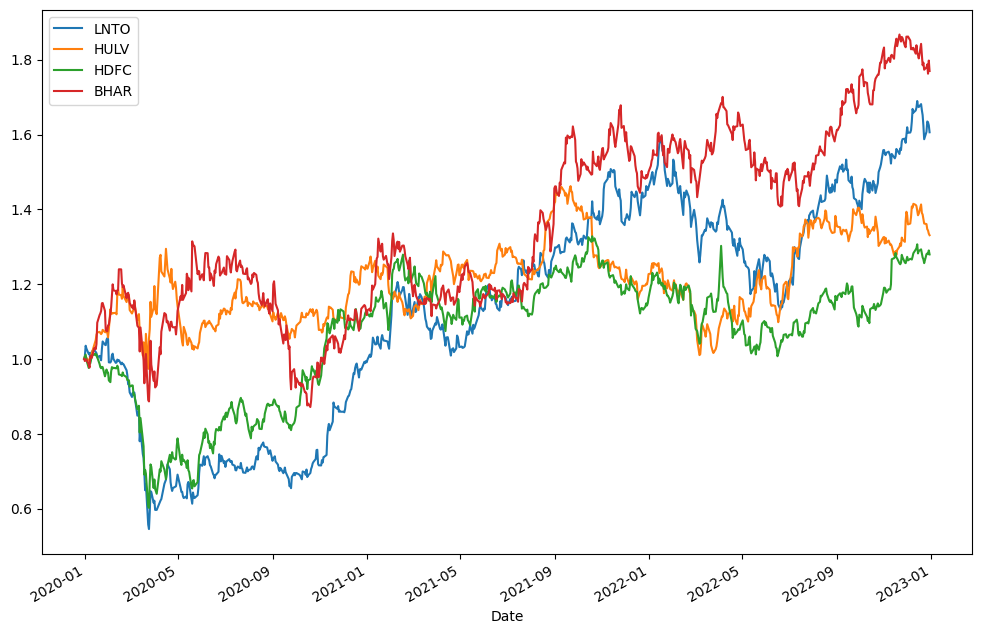

In [14]:
df = pd.merge(dfLNTO,pd.merge(dfHULV,pd.merge(dfHDFC,dfBHAR,on='Date'),on='Date'),on='Date')
df['HDFC'] = df['HDFC']/df['HDFC'][0]
df['HULV'] = df['HULV']/df['HULV'][0]
df['LNTO'] = df['LNTO']/df['LNTO'][0]
df['BHAR'] = df['BHAR']/df['BHAR'][0]

df.plot(figsize = (12,8));

#Building the Efficient Frontier

## Basic Maths with single portfolio

In [15]:
df = pd.merge(dfLNTO,pd.merge(dfHULV,pd.merge(dfHDFC,dfBHAR,on='Date'),on='Date'),on='Date')
df.head()

,LNTO,HULV,HDFC,BHAR
Date,,,,
2019-12-31,1298.95,1923.25,1271.80,455.8
2020-01-01,1310.10,1936.75,1279.05,453.3
2020-01-02,1345.00,1938.15,1286.65,455.0
2020-01-03,1335.15,1928.75,1268.10,455.0
2020-01-06,1316.30,1915.55,1241.15,449.5


Covariance and correlation are two terms that are opposed and are both used in statistics and regression analysis. Covariance shows you how the two variables differ, whereas correlation shows you how the two variables are related. Here, in this tutorial, you will explore covariance and correlation, which will help you understand the difference between covariance and correlation. <br>
https://www.simplilearn.com/covariance-vs-correlation-article

In [16]:
# Covariance Matrix of Log Returns
cov_matrix =df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,LNTO,HULV,HDFC,BHAR
LNTO,0.000395,0.000112,0.000222,0.000162
HULV,0.000112,0.000283,0.000100,0.000096
HDFC,0.000222,0.000100,0.000390,0.000165
BHAR,0.000162,0.000096,0.000165,0.000431


In [17]:
# Correlation Matrix of Log Returns
#corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
#corr_matrix

In [18]:
# Sample Portfolio Variance
# https://www.investopedia.com/ask/answers/071515/how-can-i-measure-portfolio-variance.asp
#w = {'LNTO': 0.1, 'HULV': 0.2, 'HDFC': 0.3, 'BHAR': 0.4}
w = [0.1, 0.2, 0.3, 0.4]
cov_matrix.mul(w, axis=0)
cov_matrix.mul(w, axis=0).mul(w, axis=1)
cov_matrix.mul(w, axis=0).mul(w, axis=1).sum()
cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()

p_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
p_var

0.000216926498525879

In [19]:
# Individual Mean of Annual Simple Returns
#df.resample('Y').last().pct_change()
ind_simpleReturns = df.resample('Y').last().pct_change().mean()
ind_simpleReturns

LNTO    0.187987
HULV    0.105056
HDFC    0.086446
BHAR    0.213249
dtype: float64

In [20]:
w = [0.1, 0.2, 0.3, 0.4]
p_Returns = (w*ind_simpleReturns).sum()
p_Returns

0.15104304869511745

In [21]:
# Standard Deviation annualised
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

LNTO    0.314375
HULV    0.266083
HDFC    0.312192
BHAR    0.328212
dtype: float64

In [22]:
assets = pd.concat([ind_simpleReturns, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
LNTO,0.187987,0.314375
HULV,0.105056,0.266083
HDFC,0.086446,0.312192
BHAR,0.213249,0.328212


## Iteration over Multiple Portfolios

In [23]:
p_ret = []      # Define an empty array for portfolio returns
p_vol = []      # Define an empty array for portfolio volatility
p_weights = []  # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 100000

In [24]:
%%time
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_simpleReturns) # Returns are the product of individual expected returns of asset and its  weights
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

CPU times: user 1min 53s, sys: 1.48 s, total: 1min 54s
Wall time: 2min 2s


In [25]:
#for counter, symbol in enumerate(df.columns.tolist()):
#    print(counter, symbol)

In [26]:
data = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [27]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,LNTO weight,HULV weight,HDFC weight,BHAR weight
0,0.168690,0.251207,0.402946,0.022691,0.251768,0.322595
1,0.107955,0.243190,0.140925,0.268238,0.573425,0.017412
2,0.155223,0.236184,0.264201,0.127043,0.296574,0.312182
3,0.162580,0.235299,0.058789,0.304086,0.128415,0.508710
4,0.158779,0.225231,0.163486,0.300141,0.140898,0.395475


## Plotting the Efficient Frontier

*   X-axis is Volatility - Weighted variance of Portfolio
*   Y-axis is Returns - Weighted returns of Portfolio



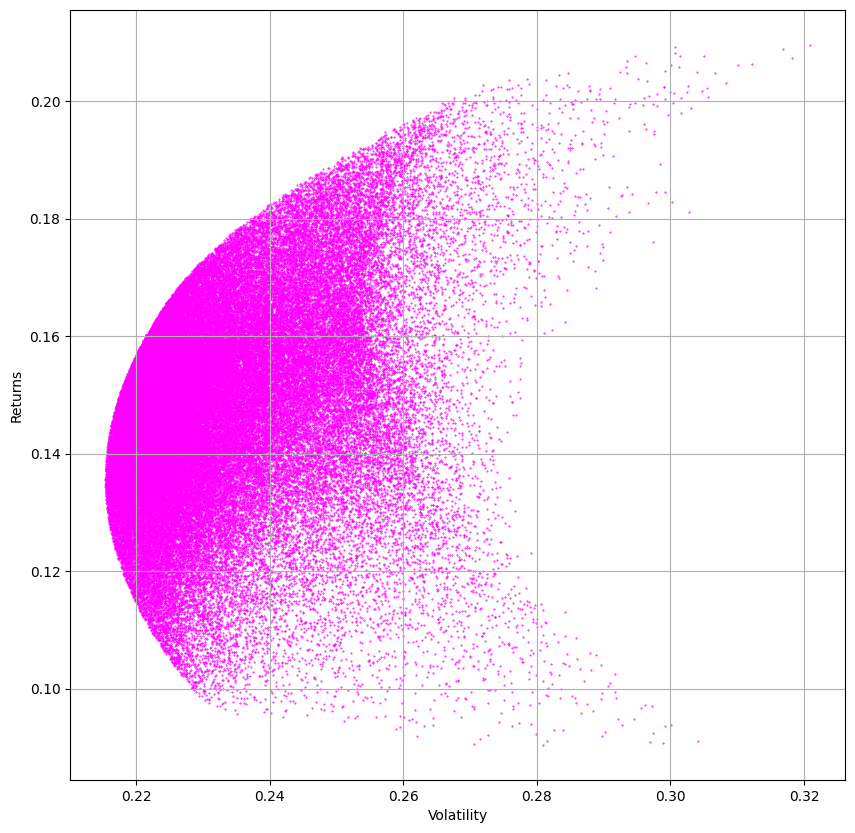

In [28]:
#Plot efficient frontier
#portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10]);
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=0.2, grid=True, figsize=[10,10], color = 'magenta');

### Minimum Volatility

In [29]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.
min_vol_port

Returns        0.135717
Volatility     0.215390
LNTO weight    0.156513
HULV weight    0.465516
HDFC weight    0.183059
BHAR weight    0.194912
Name: 68762, dtype: float64

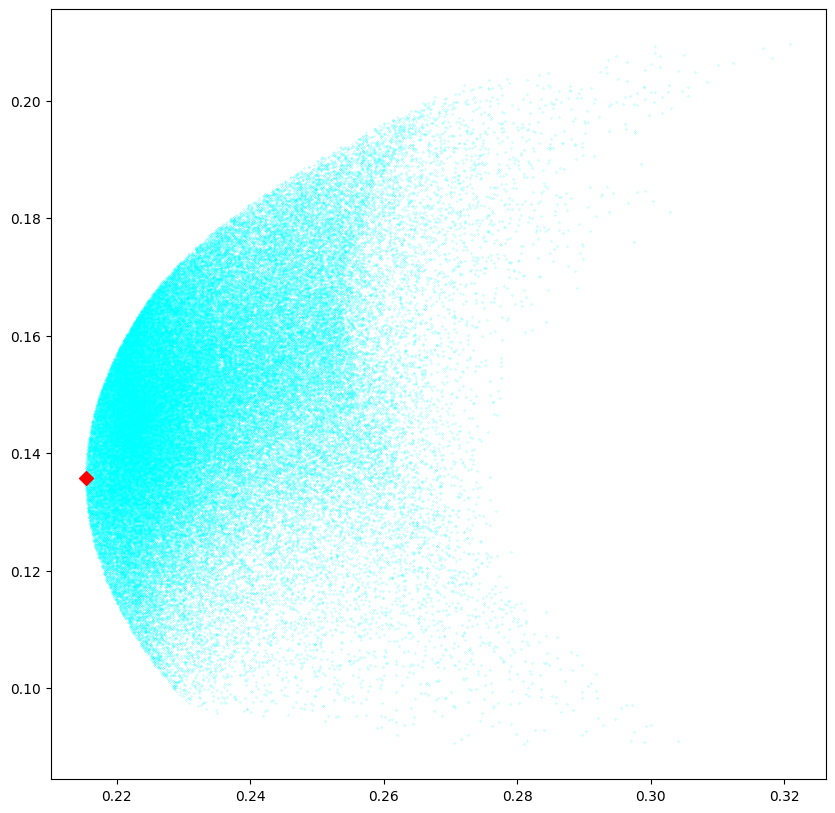

In [30]:
# Plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='.', s=0.1, color = 'cyan')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='D', s=50);

### Maximum Sharpe Ratio

In [31]:
# Findinding the optimal portfolio
rf = 0.05 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.200621
Volatility     0.267613
LNTO weight    0.429178
HULV weight    0.012704
HDFC weight    0.003244
BHAR weight    0.554874
Name: 56735, dtype: float64

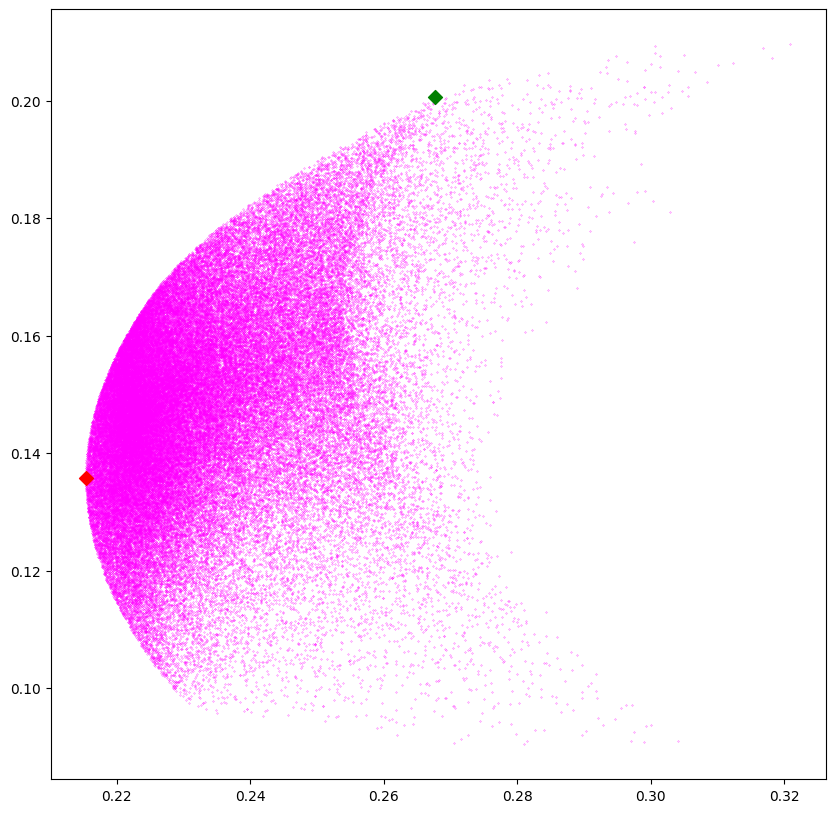

In [32]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='.', s=0.2, color = 'magenta')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='D', s=50)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='D', s=50);


### Tangency Line
https://www.financestrategists.com/wealth-management/investment-management/tangency-portfolio/

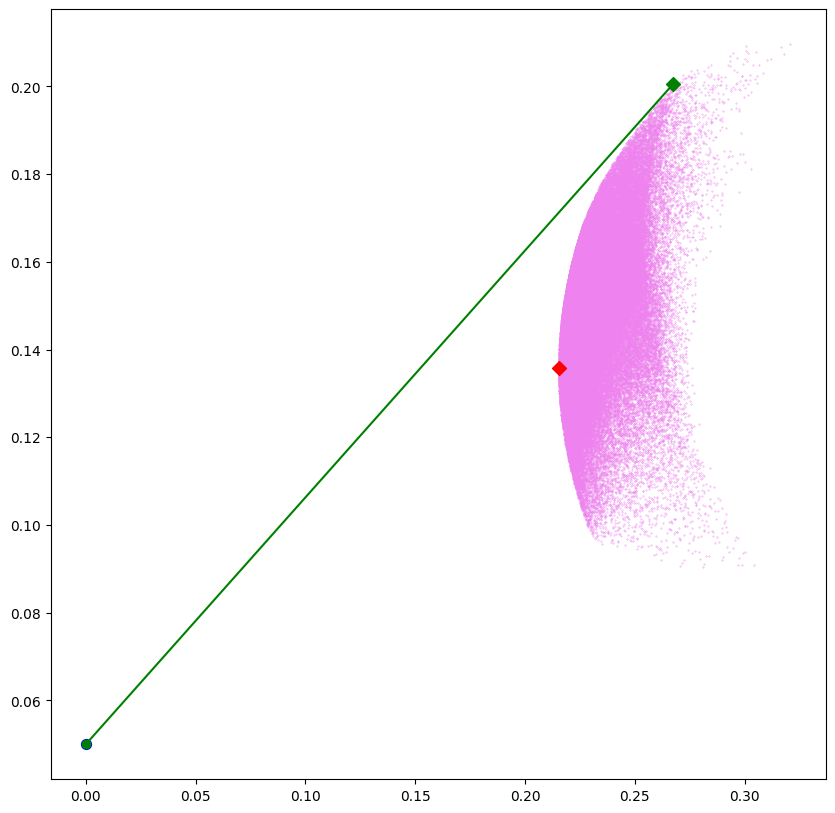

In [33]:
# Plotting Tangency Line
tangentX = [optimal_risky_port[1],0]
tangentY = [optimal_risky_port[0],rf]
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='.', s=0.3, color='violet')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='D', s=50)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='D', s=50);
plt.scatter(0,rf,color='b', marker='o', s=50);
plt.plot(tangentX, tangentY, 'go', linestyle="-");


#Chronobooks <br>
Two science fiction novels by Prithwis Mukerjee. A dystopian Earth. A technocratic society managed by artificial intelligence. Escape and epiphany on Mars. Can man and machine, carbon and silicon explore and escape into other dimensions of existence? An Indic perspective rooted in Advaita Vedanta and the Divine Feminine.  [More information](http://bit.ly/chronobooks) <br>
![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/CTCYFooter-1.png)